# 0. Loading required file from 4.1 and pre processing.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_sentiment = pd.read_csv('sentiment_features_comments.csv')

print(f"Language filtered dataset with sentiment from 4.1: {df_sentiment.shape}")
print(f"Has columns: {df_sentiment.columns.tolist()}")

Language filtered dataset with sentiment from 4.1: (271437, 10)
Has columns: ['author', 'subreddit', 'body', 'sentiment_compound', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_label', 'gender', 'gender_label']


### Preprocessing steps:
We discard unneeded columns and columns derived from others.
We apply the same pipeline as section one, which means:
Grouping bodies by author
Train test split
Tf-idf vectorization

In [3]:
#Body is the one from 4.1 filtered by language but not filtered further as can be seen from the link.
df_sentiment['body'].iloc[2]

"Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys](http://i.imgur.com/c3YKPdI.jpg)\n\nMaybe I'm just a bad player... But every time I faced one on my first playthrough, all my pawns ended up getting to 0 HP at least once and I could barely get an attack in once it started berserking."

In [4]:
df_sentiment.drop(columns=['sentiment_compound','sentiment_label'],inplace=True) #sentiment information already in sentiment_pos/neg/neu
df_sentiment.drop(columns=['gender_label'],inplace=True) #Only need one gender column
print(f"Has columns: {df_sentiment.columns.tolist()}")

Has columns: ['author', 'subreddit', 'body', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'gender']


In [5]:
#subreddit TODO for now discarding but depending on end of Section 2 may want to introduce in same manner.
df_sentiment.drop(columns=['subreddit'],inplace=True) #Only need one gender column
print(f"Has columns: {df_sentiment.columns.tolist()}")

Has columns: ['author', 'body', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'gender']


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
from scipy.sparse import csr_matrix, hstack
from sklearn.decomposition import TruncatedSVD

In [7]:
#eliminate any row with empty body.
df_sentiment = df_sentiment[df_sentiment["body"].notna() & df_sentiment["body"].str.strip().ne('')].reset_index(drop=True)

#group by author in the appropriate way for each column.
df_grouped = (
    df_sentiment
    .groupby("author", as_index=False)
    .agg({
        "body": lambda x: " ".join(x),
        "sentiment_pos": "mean",
        "sentiment_neg": "mean",
        "sentiment_neu": "mean",
        "gender": "first"                   
    })
)

df_grouped.drop(columns=['author'], inplace=True) #No longer needed 

Y = df_grouped['gender']
df_grouped.drop(columns=['gender'],inplace=True)
X = df_grouped

print(Y.shape)
print(X.shape)

(4948,)
(4948, 4)


In [8]:
#Perform the split
X_temp, X_test, Y_temp, Y_test = train_test_split(X,Y, stratify=Y, train_size=0.90,random_state=16)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, stratify=Y_temp, train_size=8/9, random_state=16)
print("80-10-10 split")
print(f"X_train shape:{X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape:{X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape:{X_test.shape}, Y_test shape: {Y_test.shape}")

80-10-10 split
X_train shape:(3958, 4), Y_train shape: (3958,)
X_val shape:(495, 4), Y_val shape: (495,)
X_test shape:(495, 4), Y_test shape: (495,)


In [9]:
#Tokenize the body column.
X_train_tokens = X_train['body']
X_val_tokens = X_val['body']
X_test_tokens = X_test['body']

# Create the vectorizer Count is Bow and percentile filter already put in.
bow = CountVectorizer( #CountVectorizer o TfidfVectorizer
    stop_words="english",
    max_df=0.99, #filter by quantile
    min_df=0.01,
    ngram_range=(1,1)
)

tfidf = TfidfVectorizer( #CountVectorizer o TfidfVectorizer
    stop_words="english",
    ngram_range=(1,1)
)

# Fit only on training data, transform validation and test data
X_train_bow = bow.fit_transform(X_train_tokens)
X_val_bow   = bow.transform(X_val_tokens)
X_test_bow  = bow.transform(X_test_tokens)

X_train_tfidf = tfidf.fit_transform(X_train_tokens)
X_val_tfidf   = tfidf.transform(X_val_tokens)
X_test_tfidf  = tfidf.transform(X_test_tokens)


#Put back with the other attributes
#Note that to be more efficient the tf-idf/bow representation is currently a scipy sparse matrix
#Our other attributes are numeric, we can convert the whole to scipy sparse matrix.
X_train.drop(columns=['body'],inplace=True)
X_train = csr_matrix(X_train) #Dense -> Sparse
tfidf_size = X_train_tfidf.shape #For illustration in next cell.
bow_size = X_train_bow.shape
X_train_bow = hstack([X_train,X_train_bow])
X_train_tfidf = hstack([X_train,X_train_tfidf])

X_val.drop(columns=['body'],inplace=True)
X_val = csr_matrix(X_val)
X_val_bow = hstack([X_val,X_val_bow])
X_val_tfidf = hstack([X_val,X_val_tfidf])

X_test.drop(columns=['body'],inplace=True)
X_test = csr_matrix(X_test)
X_test_bow = hstack([X_test,X_test_bow])
X_test_tfidf = hstack([X_test,X_test_tfidf])

In [10]:
print(X_train.shape)
print(tfidf_size)
print(X_train_tfidf.shape) #Has sentiment_pos/neg/neu added back so should be three more columns then previous.
print(bow_size)
print(X_train_bow.shape) #less columns than tf-idf as already quantile filtered.

(3958, 3)
(3958, 119477)
(3958, 119480)
(3958, 7162)
(3958, 7165)


In [11]:
svd_tfidf = TruncatedSVD(n_components=1000, random_state=42)
X_train_tfidf = svd_tfidf.fit_transform(X_train_tfidf)
X_val_tfidf= svd_tfidf.transform(X_val_tfidf)
X_test_tfidf = svd_tfidf.transform(X_test_tfidf)
print(f"TF-IDF after SVD: {X_train_tfidf.shape}")

TF-IDF after SVD: (3958, 1000)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Random Forest

We had already tested the Random Forest Model on our dataset without the sentiment attributes. We will now train this model again on the same preprocessing pipeline with the same grid search and see if we find better results.

In [ ]:
# n_estimators - number of Decision trees in the random forest.
estimators = [80,100,120,140]
#min_samples_leaf minimal number
min_samples_leaf = [1,2,3,4,6]
#function
criterion = ["gini", "entropy", "log_loss"]
#The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss”
#and “entropy” both for the Shannon information gain, see Mathematical formulation.

max_depth = [5,10,15,20,None] #None is a valid option, corresponds to infinite (no max).
#Max depth for the trees.

In [ ]:
#X_train,X_val,X_test
#Y_train,Y_val,Y_test

best_parameters = [60,1,"gini",1]
best_balanced_accuracy_score = 0
best_val_pred = None
best_test_pred = None

for est in estimators:
    for min_sam in  min_samples_leaf:
        for crit in criterion:
            for max in max_depth:
                print(f"estimators: {est}, min_samples_leaf: {min_sam}, criterion: {crit}, max: {max}")
                randomforest = RandomForestClassifier(random_state=40,n_estimators=est,min_samples_leaf=min_sam,criterion=crit,max_depth=max,class_weight='balanced')
                randomforest.fit(X_train_bow,Y_train)
                y_val_pred = randomforest.predict(X_val_bow)
                y_test_pred = randomforest.predict(X_test_bow)

                print(accuracy_score(Y_val,y_val_pred))
                print(balanced_accuracy_score(Y_val, y_val_pred))
                if balanced_accuracy_score(Y_val, y_val_pred) > best_balanced_accuracy_score:
                    best_balanced_accuracy_score = balanced_accuracy_score(Y_val, y_val_pred)
                    best_parameters = [est,min_sam,crit,max]
                    best_val_pred = y_val_pred
                    best_test_pred = y_test_pred
                print("\n")

In [ ]:
print(best_parameters)
print(f"Best Marco avg Recall on validation set: {best_balanced_accuracy_score}")

print("results on the validation data")
print(classification_report(Y_val, best_val_pred))

print("results on the test data")
print(classification_report(Y_test, best_test_pred))

# get the confusion matrix of test set
confusion_test = confusion_matrix(Y_test, best_test_pred)

# visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix on test data')
plt.show()

The best result found with the same Random Forest model the same exact grid search for the same bow - quantile filtered dataset excluding the new sentiment analysis attributes provided a best macro avg recall of 0.68 adding these three sentiment analysis attributes we instead reached a value of 0.77.

This suggests several of the decision trees have nodes that fork depending on the value of the three attributes we left, and allow in each fork a more precise model.

Clearly either the small avg difference in sentiment helps distinguish between male and female users or more complex relationships involving sentiment and the presence of other words combined have helped achieve better results.

# 2. Logistic Regression

Now that we have confirmed that sentiment analysis helps in extracting useful information regarding to the target we should try it on our best model from Section two to verify how good of a model we can create.

Start Tuning su TF-IDF SVD...
Tempo totale tuning: 7.01 secondi

Miglior configurazione: {'C': 1, 'class_weight': 'balanced'}
Miglior F1-Score (Macro CV): 0.7633

Top 5 configurazioni: (Tempo) vs (Performaces) 
   param_C param_class_weight  mean_test_score  mean_train_score  \
4      1.0           balanced         0.763300          0.839053   
7     10.0               None         0.758615          0.890907   
6     10.0           balanced         0.747557          0.906725   
9    100.0               None         0.726902          0.944744   
2      0.1           balanced         0.726445          0.750792   

   mean_fit_time  
4       0.330528  
7       1.190413  
6       0.756298  
9       1.104966  
2       0.273396  


              precision    recall  f1-score   support

           0       0.87      0.86      0.86       362
           1       0.63      0.65      0.64       133

    accuracy                           0.80       495
   macro avg       0.75      0.76      0.75   

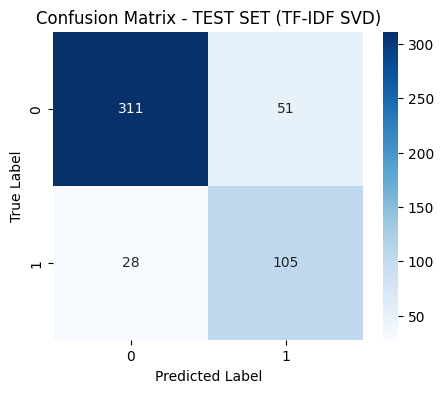

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
import pandas as pd
import matplotlib.pyplot as plt

# X_train_tfidf, X_val_tfidf, X_test_tfidf
# Y_train, Y_val, Y_test

# Map local values to variable names used by Model-rocco.ipynb
X_train_tune = X_train_tfidf
y_train_tune = Y_train
X_val_tune   = X_val_tfidf
y_val_tune   = Y_val
X_tfidfsvd_test = X_test_tfidf
y_tfidfsvd_test = Y_test
#Same code as Model-rocco.ipynb now.

# 1. Griglia dei parametri
# Dato che l'overfitting è basso, esploriamo anche C più alti (fino a 100) per vedere se
# il modello può imparare qualcosa in più senza perdere generalizzazione.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced', None] # Helping Women
}

print("Start Tuning su TF-IDF SVD...")
start_time = time.time()

# 2. Configuration
grid_search = GridSearchCV(
    LogisticRegression(random_state=16, max_iter=2000, solver='lbfgs'),
    param_grid,
    cv=5,
    scoring='f1_macro', # Ottimizziamo la media tra le due classi
    n_jobs=-1,
    return_train_score=True # Utile per vedere l'overfitting per ogni parametro
)

grid_search.fit(X_train_tune, y_train_tune)

end_time = time.time()
print(f"Tempo totale tuning: {end_time - start_time:.2f} secondi")

# 3. Analisi dei Risultati
print("\nMiglior configurazione:", grid_search.best_params_)
print(f"Miglior F1-Score (Macro CV): {grid_search.best_score_:.4f}")

# Creiamo un DataFrame per un'analisi più comoda
results_df = pd.DataFrame(grid_search.cv_results_)
cols = ['param_C', 'param_class_weight', 'mean_test_score', 'mean_train_score', 'mean_fit_time']
print("\nTop 5 configurazioni: (Tempo) vs (Performaces) ")
print(results_df[cols].sort_values(by='mean_test_score', ascending=False).head(5))

# 4. Validazione Finale
best_model = grid_search.best_estimator_
y_pred_val_opt = best_model.predict(X_val_tune)
print("\n")
print(classification_report(y_val_tune, y_pred_val_opt))


# Final evaluation on TEST set (not validation!)
y_pred_test = best_model.predict(X_tfidfsvd_test)
print("=== FINAL TEST SET PERFORMANCE ===")
print(classification_report(y_tfidfsvd_test, y_pred_test))

# Confusion matrix for test set
cm_test = confusion_matrix(y_tfidfsvd_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TEST SET (TF-IDF SVD)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=== FINAL TEST SET PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       362
           1       0.67      0.79      0.73       133

    accuracy                           0.84       495
   macro avg       0.80      0.82      0.81       495
weighted avg       0.85      0.84      0.84       495



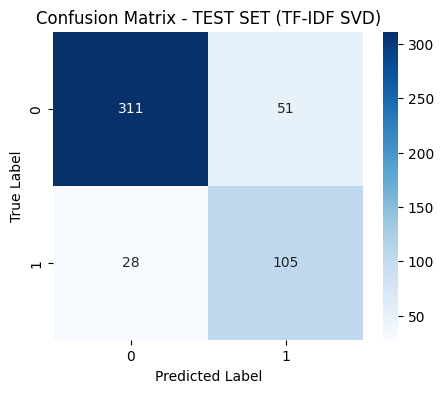

In [14]:
# Final evaluation on TEST set (not validation!)
y_pred_test = best_model.predict(X_tfidfsvd_test)
print("=== FINAL TEST SET PERFORMANCE ===")
print(classification_report(y_tfidfsvd_test, y_pred_test))

# Confusion matrix for test set
cm_test = confusion_matrix(y_tfidfsvd_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TEST SET (TF-IDF SVD)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

We now have a best macro avg recall of 0.82 a rather stunning result considering the difficulty of predicting the gender from the comments. Adding VADER sentiment features (positive, negative, and neutral scores) to the BoW-based gender classification models led to a substantial performance improvement. In particular, the logistical regression model’s macro-averaged recall increased from 0.71 to 0.82, indicating better balanced performance across genders despite the class imbalance. This suggests that emotional tone provides complementary information to lexical features, capturing patterns that are not well represented by TF-IDF alone. The result highlights that sentiment is a meaningful signal for gender prediction.